In [35]:
## Loading the relevant packages
library(dplyr);library(lubridate);library(caret)
library(tidyr);library(forecastML);library(zoo)
library(xgboost);library(randomForest);library(glmnet);library(readxl)

In [46]:
#df <- read.csv("2016_20_Anand_Vihar.csv", na.strings = "None")
## Data cleaning 
## Reading the excel file, starting with 12 line and giving NA as None
df <- read_xlsx('Data/Anand_Vihar_16_21.xlsx',skip = 12,na = "None")
## converting date into proper date format and selecting the relevant variable needed
df <- df %>% mutate(date = dmy_hm(`From Date`,tz="Asia/Kolkata"),PM25=`PM2.5`)%>%
select(date,PM25,AT,RH,WS,SR,WD)
head(df)

date,PM25,AT,RH,WS,SR,WD
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016-01-01 01:00:00,376.00,11.43,69.00,0.30,12.25,216.25
2016-01-01 02:00:00,480.50,11.28,71.50,0.35,12.58,230.92
2016-01-01 03:00:00,486.67,11.71,71.83,0.31,12.33,203.25
2016-01-01 04:00:00,441.17,11.13,73.08,0.30,12.75,126.92
2016-01-01 05:00:00,594.83,11.01,74.75,0.30,12.58,196.42
2016-01-01 06:00:00,441.33,11.49,74.17,0.37,13.83,80.58


In [47]:
## Converting the data into daily time series
daily_df <- df %>%
  select(date, PM25) %>% # to check the model for PM2.5 replace PM2.5 by PM2.5
  # extract date features
  mutate(
    date = as.POSIXct(date, format = "%d-%m-%Y %H:%M"), #Date format
    hour = hour(date),
    day = day(date),
    month = month(date),
    year = year(date),
    dates = as.Date(paste0(day, "-", month, "-", year), "%d-%m-%Y"),
    PM2.5 = ifelse(PM25 <=10,NA,PM25)
  ) %>%
  # from hourly to daily
  group_by(dates, day, month, year) %>% ## Convert hourly to daily 
  summarise(PM2.5_daily = mean(PM2.5, na.rm = TRUE)) %>%
  mutate(week = week(dates))

## Putting NA if there are null values 
daily_df$PM2.5_daily[is.nan(daily_df$PM2.5_daily)] <- NA


`summarise()` has grouped output by 'dates', 'day', 'month'. You can override using the `.groups` argument.



In [48]:
######################## Seasonal Indexes #####################################

## We creating index of seasons from the data till May 2019

seasonalIndex <- daily_df %>% filter(dates < as.Date("2019-05-01"))


############################### daily seasonality  #######################
daily_s <- seasonalIndex %>% group_by(year, month, day) %>%
  summarize(average = mean(PM2.5_daily, na.rm = TRUE))

daily_s$average[is.nan(daily_s$average)] <- NA

## Spanning the year wise value column wise
daily_s <- daily_s %>% ungroup() %>%
  spread(year, average)
head(daily_s)

# Calcuating the mean daily index over the years (Except first and second columns)
daily_s$meanindex <- rowMeans(daily_s[, -c(1,2)], na.rm = TRUE)

## Summary mean is the mean of Mean index
summary_mean <- daily_s %>% ungroup() %>%
  summarize(summary_mean = mean(meanindex, na.rm = T))

## We merge the Summary mean with our old data frame 
daily_s <- merge(daily_s, summary_mean)

## Finally calculating the daily index by mean index/ summary mean * 100
daily_s <-
  daily_s %>% mutate(dailyindex = meanindex / summary_mean * 100)

head(daily_s)


`summarise()` has grouped output by 'year', 'month'. You can override using the `.groups` argument.



month,day,2016,2017,2018,2019
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,359.5730,199.8817,481.6250,380.2292
1,2,327.9150,257.1204,359.6667,418.4688
1,3,341.3188,271.6446,287.7083,412.8854
1,4,480.0688,270.1217,351.6250,291.9479
1,5,433.3537,246.8504,306.2500,241.6667
1,6,371.7995,189.3525,324.7500,191.8542


,month,day,2016,2017,2018,2019,meanindex,summary_mean,dailyindex
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,359.5730,199.8817,481.6250,380.2292,355.3272,152.2606,233.3679
2,1,2,327.9150,257.1204,359.6667,418.4688,340.7927,152.2606,223.8221
3,1,3,341.3188,271.6446,287.7083,412.8854,328.3893,152.2606,215.6759
4,1,4,480.0688,270.1217,351.6250,291.9479,348.4408,152.2606,228.8451
5,1,5,433.3537,246.8504,306.2500,241.6667,307.0302,152.2606,201.6479
6,1,6,371.7995,189.3525,324.7500,191.8542,269.4391,152.2606,176.9592


In [49]:
############################### weekly seasonality ###########
weekly_s <- seasonalIndex %>%
  group_by(year, week) %>%
  summarize(average = mean(PM2.5_daily, na.rm = TRUE))

## NA if the average in null
weekly_s$average[is.nan(weekly_s$average)] <- NA

## Spreading across weeks
weekly_s <- weekly_s %>% ungroup() %>%
  spread(year, average)

head(weekly_s)

# Calcuating the mean weekly index over the years
weekly_s$meanindex <- rowMeans(weekly_s[, -1], na.rm = TRUE)

## Calculting summary means
summary_mean <- weekly_s %>% ungroup() %>%
  summarize(summary_mean = mean(meanindex, na.rm = T))

## Adding summary mean
weekly_s <- merge(weekly_s, summary_mean)

## Calculating weekly index
weekly_s <-
  weekly_s %>% mutate(weeklyindex = meanindex / summary_mean * 100)

head(weekly_s)

`summarise()` has grouped output by 'year'. You can override using the `.groups` argument.



week,2016,2017,2018,2019
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,397.4355,225.5635,336.2440,304.9851
2,319.8503,174.3115,274.4787,245.0446
3,246.5255,165.8277,282.3517,294.3720
4,341.2351,157.3748,208.5647,111.7974
5,250.6284,193.1171,154.7107,199.7812
6,229.8844,140.2679,197.2083,160.8165


,week,2016,2017,2018,2019,meanindex,summary_mean,weeklyindex
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,397.4355,225.5635,336.2440,304.9851,316.0571,155.898,202.7332
2,2,319.8503,174.3115,274.4787,245.0446,253.4213,155.898,162.5558
3,3,246.5255,165.8277,282.3517,294.3720,247.2692,155.898,158.6096
4,4,341.2351,157.3748,208.5647,111.7974,204.7430,155.898,131.3313
5,5,250.6284,193.1171,154.7107,199.7812,199.5593,155.898,128.0063
6,6,229.8844,140.2679,197.2083,160.8165,182.0443,155.898,116.7714


In [50]:
############################### monthly seasonality ##############################

## Grouping by year and month
monthly_s <- seasonalIndex %>%
  group_by(year, month) %>%
  summarize(average = mean(PM2.5_daily, na.rm = TRUE))

## Adding NA values if there are any null values of any sort 
monthly_s$average[is.nan(monthly_s$average)] <- NA

## Spreading across months 
monthly_s <- monthly_s %>% ungroup() %>%
  spread(year, average)

head(monthly_s)

# Calcuating the mean weekly index over the years (-1 to remove first column which is month)
monthly_s$meanindex <- rowMeans(monthly_s[, -1], na.rm = TRUE)

## Summary mean of the mean index
summary_mean <- monthly_s %>% ungroup() %>%
  summarize(summary_mean = mean(meanindex, na.rm = T))

## Merging the summary mean with the data frame
monthly_s <- merge(monthly_s, summary_mean)

## Adding the Monthly index
monthly_s <-
  monthly_s %>% mutate(monthlyindex = meanindex / summary_mean * 100)
head(monthly_s)

`summarise()` has grouped output by 'year'. You can override using the `.groups` argument.



month,2016,2017,2018,2019
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,329.30722,182.5829,265.5462,235.87494
2,166.68875,138.3392,161.2071,141.88165
3,121.33565,113.1674,119.2262,106.87930
4,149.94428,129.5753,115.1012,98.01637
5,101.07827,150.6213,107.3090,NA
6,92.98106,102.3051,112.9941,NA


,month,2016,2017,2018,2019,meanindex,summary_mean,monthlyindex
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,329.30722,182.5829,265.5462,235.87494,253.3278,154.8724,163.57196
2,2,166.68875,138.3392,161.2071,141.88165,152.0292,154.8724,98.16414
3,3,121.33565,113.1674,119.2262,106.87930,115.1521,154.8724,74.35291
4,4,149.94428,129.5753,115.1012,98.01637,123.1593,154.8724,79.52306
5,5,101.07827,150.6213,107.3090,NA,119.6695,154.8724,77.26975
6,6,92.98106,102.3051,112.9941,NA,102.7601,154.8724,66.35145


In [51]:

############# Join the indexes to original daily data
daily_s <- daily_s %>% select(month, day, dailyindex)
daily_df <- daily_df %>% left_join(daily_s, by = c("month", "day"))

monthly_s <- monthly_s %>% select(month, monthlyindex)
daily_df <- daily_df %>% left_join(monthly_s, by = c("month"))

weekly_s <- weekly_s %>% select(week, weeklyindex)
daily_df <- daily_df %>% left_join(weekly_s, by = c("week"))

head(daily_df)
## Removing the unnecessary data frames 
rm(daily_s)
rm(monthly_s)
rm(weekly_s)
rm(summary_mean)
rm(seasonalIndex)


In [56]:
################### Data manipulation using forecastML
## Fill_gaps is a function from forecatML to see if there are missing value it creates
## an evenly spaced data frame
daily_ts <- fill_gaps(daily_df, date_col = 1, frequency = "1 day")
dates <- daily_ts$dates
daily_ts$dates <- NULL
daily_ts$day <- NULL
daily_ts$month <- NULL
daily_ts$week <- NULL
head(daily_ts)


,year,PM2.5_daily,dailyindex,monthlyindex,weeklyindex
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2016,359.5730,233.3679,163.572,202.7332
2,2016,327.9150,223.8221,163.572,202.7332
3,2016,341.3188,215.6759,163.572,202.7332
4,2016,480.0688,228.8451,163.572,202.7332
5,2016,433.3537,201.6479,163.572,202.7332
6,2016,371.7995,176.9592,163.572,202.7332


In [76]:
## Now creating a training data frame with lookback of 7 days 
data_train <-
  create_lagged_df(
    daily_ts, ## data frame
    type = "train", ## training 
    outcome_col = 2,## Output column is PM2.5 
    horizons = 1, ## Horizons is used if you want to use different models in different time frames
    lookback = c(1:7),## Lookback of 7 hour
    dates = dates, ## dates vector
    dynamic_features = c("year", "dailyindex", "monthlyindex", "weeklyindex"), ## dynamic features of index
    frequency = "1 day" ## Frequency is 1 day
  )
## Looking at the first horizon data frame
head(data_train$horizon_1)


,PM2.5_daily,PM2.5_daily_lag_1,PM2.5_daily_lag_2,PM2.5_daily_lag_3,PM2.5_daily_lag_4,PM2.5_daily_lag_5,PM2.5_daily_lag_6,PM2.5_daily_lag_7,year,dailyindex,monthlyindex,weeklyindex
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8,519.5942,468.0200,371.7995,433.3537,480.0688,341.3188,327.9150,359.5730,2016,162.9493,163.572,162.5558
9,169.4908,519.5942,468.0200,371.7995,433.3537,480.0688,341.3188,327.9150,2016,136.7077,163.572,162.5558
10,281.5725,169.4908,519.5942,468.0200,371.7995,433.3537,480.0688,341.3188,2016,137.6187,163.572,162.5558
11,409.0429,281.5725,169.4908,519.5942,468.0200,371.7995,433.3537,480.0688,2016,183.8607,163.572,162.5558
12,286.4671,409.0429,281.5725,169.4908,519.5942,468.0200,371.7995,433.3537,2016,202.9174,163.572,162.5558
13,313.1204,286.4671,409.0429,281.5725,169.4908,519.5942,468.0200,371.7995,2016,204.6545,163.572,162.5558


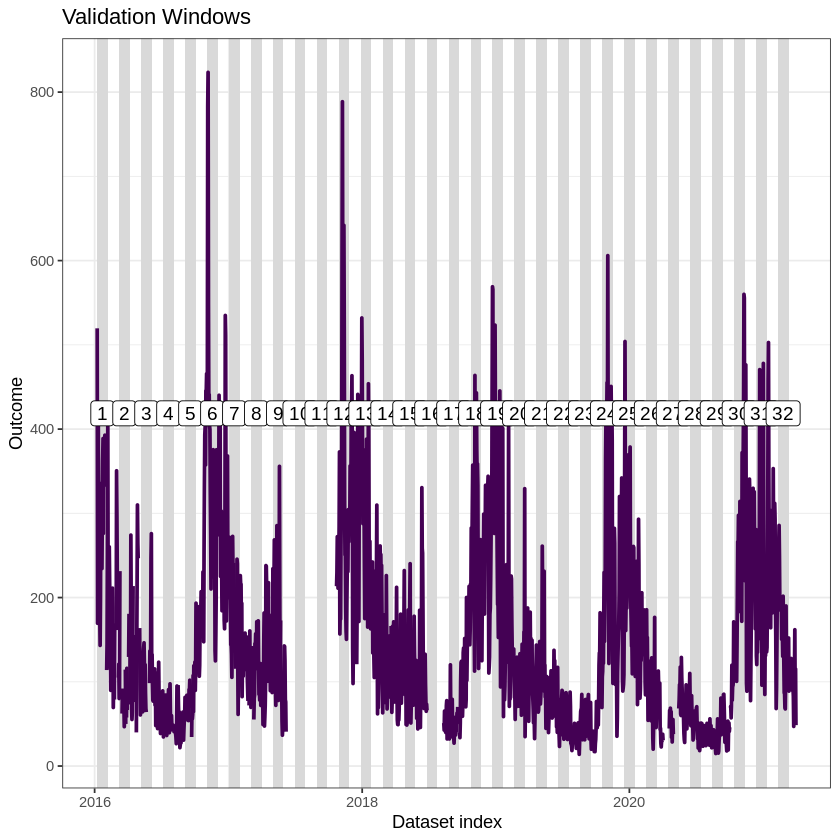

In [77]:
# impute the independent variables
impute_indeps <- function(data){
  cnames <- colnames(data) ## Colnames of dataframe
  if(length(grep("lag", cnames)) > 0){ 
    data[, grep("lag", cnames)] <- na.approx(data[, grep("lag", cnames)]) ## Missing values are interpolated
  } 
  return(data)
}

data_train$horizon_1 <- impute_indeps(data_train$horizon_1)
data_train$horizon_7 <- impute_indeps(data_train$horizon_7)
data_train$horizon_14 <- impute_indeps(data_train$horizon_14)
data_train$horizon_30 <- impute_indeps(data_train$horizon_30)

#------------------------------------------------------------------------------
# Create validation datasets for outer-loop nested cross-validation.
windows <- create_windows(data_train, window_length = 30, skip = 30)
plot(windows, data_train)

In [87]:
#------------------------------------------------------------------------------
# User-define model - Linear Regression
model_function_LinReg <- function(data, my_outcome_col) {
  outcome_names <- names(data)[my_outcome_col] ## The output column which you would like to predict PM2.5 in this case
  model_formula <- formula(paste0(outcome_names,  "~ .")) ## Model formulae in the format
  model <- lm(model_formula, data = data) ## Linear model in this case
  return(model)
}

model_results_LinReg <- train_model(
  data_train, ## Training data
  windows = windows, ## The windows
  model_name = "LinReg", ## Linear Regressing
  model_function = model_function_LinReg, ## The model function
  my_outcome_col = 1, ## First column (PM2.5 daily)
  use_future = FALSE 
)


,PM2.5_daily,PM2.5_daily_lag_1,PM2.5_daily_lag_2,PM2.5_daily_lag_3,PM2.5_daily_lag_4,PM2.5_daily_lag_5,PM2.5_daily_lag_6,PM2.5_daily_lag_7,year,dailyindex,monthlyindex,weeklyindex
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8,519.5942,468.0200,371.7995,433.3537,480.0688,341.3188,327.9150,359.5730,2016,162.9493,163.572,162.5558
9,169.4908,519.5942,468.0200,371.7995,433.3537,480.0688,341.3188,327.9150,2016,136.7077,163.572,162.5558
10,281.5725,169.4908,519.5942,468.0200,371.7995,433.3537,480.0688,341.3188,2016,137.6187,163.572,162.5558
11,409.0429,281.5725,169.4908,519.5942,468.0200,371.7995,433.3537,480.0688,2016,183.8607,163.572,162.5558
12,286.4671,409.0429,281.5725,169.4908,519.5942,468.0200,371.7995,433.3537,2016,202.9174,163.572,162.5558
13,313.1204,286.4671,409.0429,281.5725,169.4908,519.5942,468.0200,371.7995,2016,204.6545,163.572,162.5558


In [23]:
##################### LASSO model ###########################
model_function_LASSO <- function(data, my_outcome_col) {
    ## Completing the data 
  data <- data[complete.cases(data),]
    ## Constant features basically all the independent variables
  constant_features <-
    which(unlist(lapply(data[, -(my_outcome_col)], function(x) {
      !(length(unique(x)) > 1)
    })))
  ## If the contant_feature is greater than 1  
  if (length(constant_features) > 1) {
    data <-
      data[, -c(constant_features + 1)]  # +1 because we're skipping over the outcome column.
  }
  
    ## All the columns except the dependent variables
  x <- data[, -(my_outcome_col), drop = FALSE]
    ## My dependent variables
  y <- data[, my_outcome_col, drop = FALSE]
    ## Converting x into matrix
  x <- as.matrix(x, ncol = ncol(x))
    ## Converting y into matrix
  y <- as.matrix(y, ncol = ncol(y))
      ## Now training the lasso model
  model <- cv.glmnet(x, y)
  return(list("model" = model, "constant_features" = constant_features))
}


model_results_LASSO <- train_model(
  data_train, ## data_train 
  windows = windows, ## windows
  model_name = "LASSO", ## Model name as lasso
  model_function = model_function_LASSO, ## Model function is LASSO which we defined up
  my_outcome_col = 1, ## Output column in the first column in the dataframe which will also go in the model_function_LASSO
  use_future = FALSE  
)




In [24]:
# User-define model - Random Forest
model_function_RF <- function(data, my_outcome_col) {
  outcome_names <- names(data)[my_outcome_col] ## Output column that will be defined
  model_formula <- formula(paste0(outcome_names,  "~ .")) ## model formulae (like PM2.5_daily ~ .)
  set.seed(224) ## Setting the seed
  model <-
    randomForest(
      formula = model_formula, ## model_formulae
      data = data, ## the data
      ntree = 500, # try 100, 200, 300, 400, 500 and store the results
      mtry = 4, # try 2, 3, 4, 5
      na.action = na.omit ## Removing missing values if any
    )
}

model_results_RF <- train_model(
  data_train, ## data_train 
  windows = windows, ## windows
  model_name = "RF", ## Model name is Random forest 
  model_function = model_function_RF, ## Model function we defined up
  my_outcome_col = 1, ## Output column is the first column in the dataframe (PM2.5 daily which will also go on Model function)
  use_future = FALSE
)




In [88]:
# User-define model - XGBoost
model_function_xgb <- function(data, my_outcome_col) {

  # xgboost cannot handle missing outcomes data.
  data <- data[complete.cases(data),]
  ## Getting the number of rows
  indices <- 1:nrow(data)
  ## defining the seed
  set.seed(224)
  ## Training the indices - this is how in XGBoost it works (Dividing in train and test)
  train_indices <- sample(1:nrow(data), ceiling(nrow(data) * .8), replace = FALSE)
  ## Test indices
  test_indices <- indices[!(indices %in% train_indices)]
  ## Training the model
  data_train <- xgboost::xgb.DMatrix(data = as.matrix(data[train_indices, 
                                                           -(my_outcome_col), drop = FALSE]),
                                     label = as.matrix(data[train_indices, 
                                                            my_outcome_col, drop = FALSE]))
  ## Testing the model
  data_test <- xgboost::xgb.DMatrix(data = as.matrix(data[test_indices, 
                                                          -(my_outcome_col), drop = FALSE]),
                                    label = as.matrix(data[test_indices, 
                                                           my_outcome_col, drop = FALSE]))
  ## Objective is R2 value
  params <- list("objective" = "reg:squarederror")
  watchlist <- list(train = data_train, test = data_test)
  
  
  set.seed(224)
  model <- xgboost::xgb.train(data = data_train, params = params, ## Parameters 
                              max_depth = 3, # try 2, 3, 4, 5, 6 and store the results 
                              eta = 0.3, # try 0.1, 0.5 and store the results 
                              nthread = 2, nrounds = 75,
                              eval_metric = "rmse", verbose = 0, 
                              early_stopping_rounds = 5, 
                              watchlist = watchlist
                              )
  
  return(model)
}


model_results_xgb <- train_model(
  data_train, ## Training data
  windows = windows,  ## Windows
  model_name = "xgboost", ## XGBoost 
  model_function = model_function_xgb, ## XGBoost model function
  my_outcome_col = 1, ## Output column is 1 (PM2.5 daily)
  use_future = FALSE
)


In [89]:
## Defining the prediction function (Linear model)
prediction_function <- function(model, data_features) {
  data_pred <- data.frame("y_pred" = predict(model, data_features))
  return(data_pred)
}



In [92]:
## Prediction function for LASSO
prediction_function_LASSO <- function(model, data_features) {
  if (length(model$constant_features) > 1) {
    # 'model' was passed as a list.
    data_features <- data_features[, -c(model$constant_features)]
  }
  
  # data_features <- data_features[complete.cases(data_features), ]
  x <- as.matrix(data_features, ncol = ncol(data_features))
  data_pred <-
    data.frame("y_pred" = predict(model$model, x, s = "lambda.min"))
  return(data_pred)
}



In [93]:
## Prediction function for XGB
prediction_function_xgb <- function(model, data_features) {
    
  x <- xgboost::xgb.DMatrix(data = as.matrix(data_features))
  data_pred <- data.frame("y_pred" = predict(model, x)) 
  return(data_pred)
}


In [100]:
data_results <- predict(
  model_results_LinReg,
  model_results_RF,
  model_results_LASSO,
  model_results_xgb,
  prediction_function = list(
    prediction_function,
    prediction_function,
    prediction_function_LASSO,
    prediction_function_xgb
  ),
  data = data_train
)




Warning message in return_error(data_results):
“'rmsse' was not calculated. The 'rmsse' metric needs a dataset of actuals passed in 'data_test' and 'test_indices'.”


model,window_start,window_stop,mae,mape,mdape,smape,rmse
<chr>,<date>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LASSO,2016-01-08,2016-01-08,33.56199,28.16205,20.12841,25.77191,44.47893
LinReg,2016-01-08,2016-01-08,33.56527,28.15181,19.69571,26.07784,44.55176
RF,2016-01-08,2016-01-08,33.50314,29.14834,20.98254,26.08092,44.21527
xgboost,2016-01-08,2016-01-08,33.12440,28.25007,21.65839,26.20480,43.77293


Warning message:
“Removed 8 rows containing missing values (geom_point).”


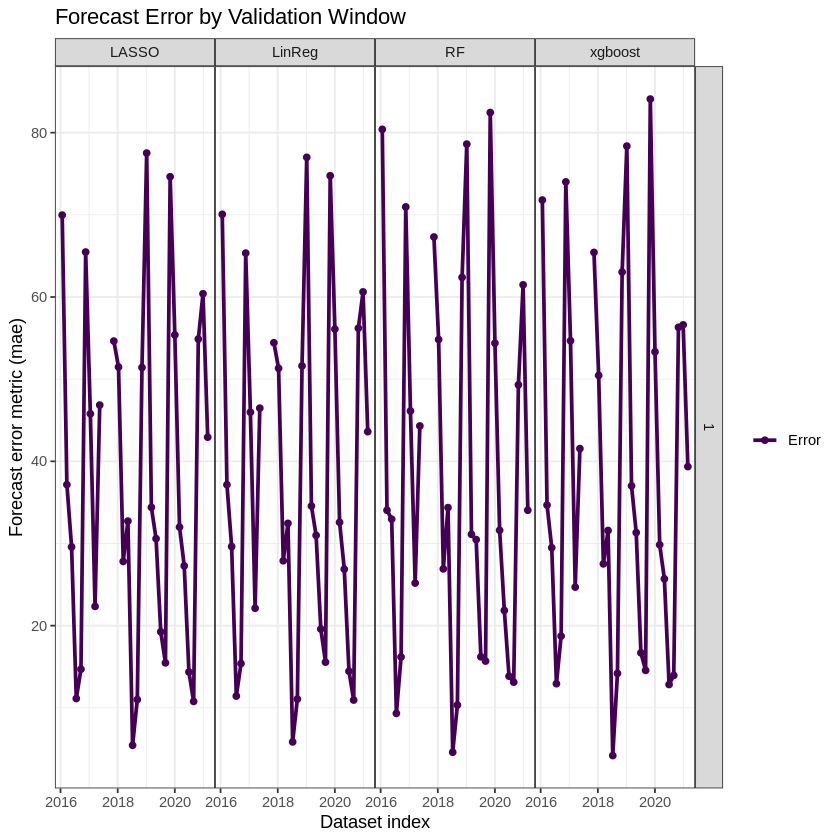

In [98]:
data_error <- return_error(data_results)
data_error$error_global
plot(data_error,
     type = "window",
     facet_free = ~ model,
     horizons = 1)
